In [1]:
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess 
from gensim.models.coherencemodel import CoherenceModel 
from gensim.models.ldamodel import LdaModel
import spacy
import nltk
import pyLDAvis 
import warnings
import pickle
import json
from gensim.models import TfidfModel
import matplotlib.pyplot as plt
import re
from pprint import pprint
import pandas as pd
import time
from gensim.test.utils import datapath
from gensim import corpora, models, similarities
from datetime import datetime
import yfinance as yf
import pandas_datareader as pdr
import requests


warnings.filterwarnings("ignore")

In [2]:
def get_fred_data(param_list, start_date, end_date):
    df = pdr.DataReader(param_list, 'fred', start_date, end_date)
    return df
    

In [3]:
df_conv1 = pd.read_pickle('C:/Users/senic/OneDrive/Desktop/Masters/WINTER_2021/ECO2460/Term_Paper/Code/Sentiment/corpus_sentiment_sam.pkl')
df_conv2 = pd.read_csv('C:/Users/senic/OneDrive/Desktop/Masters/WINTER_2021/ECO2460/Term_Paper/Code/Sentiment/IMPORTANT_SENTIMENT.csv')
df_conv3 = pd.read_csv('C:/Users/senic/OneDrive/Desktop/Masters/WINTER_2021/ECO2460/Term_Paper/Code/Sentiment/IMPORTANT_SENTIMENT_2.csv')

df_conv1 = pd.DataFrame(df_conv1)
df_conv2 = df_conv2.drop('Unnamed: 0', axis=1)
df_conv3 = df_conv3.drop('Unnamed: 0', axis=1)

sent_list = []
for index, row in df_conv1.iterrows():
    c = 0
    for i in range(0,5):
        if row[i] == 'POSITIVE':
            c += 1
        elif row[i] == 'NEGATIVE':
            c -= 1
    
    if c > 0:
        sent_list.append('POSITIVE')
    elif c < 0:
        sent_list.append('NEGATIVE')
    else:
        sent_list.append('NEUTRAL')
    
for index, row in df_conv2.iterrows():
    c = 0
    for i in range(0,5):
        if row[i] == 'POSITIVE':
            c += 1
        elif row[i] == 'NEGATIVE':
            c -= 1
    
    if c > 0:
        sent_list.append('POSITIVE')
    elif c < 0:
        sent_list.append('NEGATIVE')
    else:
        sent_list.append('NEUTRAL')
        
for index, row in df_conv3.iterrows():
    c = 0
    for i in range(0,5):
        if row[i] == 'POSITIVE':
            c += 1
        elif row[i] == 'NEGATIVE':
            c -= 1
    
    if c > 0:
        sent_list.append('POSITIVE')
    elif c < 0:
        sent_list.append('NEGATIVE')
    else:
        sent_list.append('NEUTRAL')

print(len(sent_list))

79910


In [4]:
df = pd.read_pickle('C:/Users/senic/OneDrive/Desktop/Masters/WINTER_2021/ECO2460/Term_Paper/Code/Replication_Data/cleaned_WSJ_data_V2.pkl')


In [5]:
lda_model = models.LdaModel.load('C:/Users/senic/OneDrive/Desktop/Masters/WINTER_2021/ECO2460/Term_Paper/Code/models/50_model_slow_V5.model')

lda_model

In [6]:
#This sentiment is using the first sentiment file that Sam sent
sent_df = pd.read_pickle('C:/Users/senic/OneDrive/Desktop/Masters/WINTER_2021/ECO2460/Term_Paper/Code/Replication_Data/WSJ_financial_sentiment_transformer.pkl')

sent_df

#change to -1.2, -1.0 for alternative weighting scheme
sent_trans = {'neutral': 0, 'negative': -1, 'positive': 1, 'POSITIVE': 1, 'NEGATIVE': -1, 'NEUTRAL': 0}

sents_1_bin = []
#for row in sent_df:
for row in sent_list:
    #sents_1_bin.append(sent_trans[row[0]['label']])
    sents_1_bin.append(sent_trans[row])

df['sent_bin'] = sents_1_bin

## Develop the sentiment time series datasets

In [7]:
weights_1 = []
weights_2 = []
weights_3_pos = []
weights_3_neg = []
weights_4_pos = []
weights_4_neg = []
dates = []
years = [i for i in range(2006, 2018)]
months = [i for i in range(1,13)]
days = [i for i in range(1,33)]
tops = 190
corpus = df['corpus'].tolist()


c = 0
l = 365 * 12
#loop thru each month and year
for y in years:
    for m in months:
        for d in days:
            #check if this is a weekend
            try:
                if datetime(y, m, d).weekday() > 4:
                    #print('weekend',y,m,d)
                    c+=1
                    continue
            except:
                #print('invalid', y,m,d)
                c+=1
                continue
            
            #count the documents in teh current day and accumulate the predicted weight of each topic within the documents
            doc_count = 0
            acc_weight_1 = np.zeros(tops)
            acc_weight_2 = np.zeros(tops)
            acc_weight_3_pos = np.zeros(tops)
            acc_weight_3_neg = np.zeros(tops)
            acc_weight_4_pos = np.zeros(tops)
            acc_weight_4_neg = np.zeros(tops)
            
            #get all rows in the dataframe equal to the current day month and year
            temp_df = df.loc[(df['year'] == y) & (df['month'] == m) & (df['day'] == d), ['title', 'sent_bin']]
            
            for index, row in temp_df.iterrows():
                
                new_weight = lda_model[corpus[index]]
                ind = new_weight.index(max(new_weight))
                
                #get the weights for the first sentiment option #1
                for weight in new_weight:
                    acc_weight_1[weight[0]] += weight[1] * row['sent_bin']
            
                    #produce option #4
                    if row['sent_bin'] == 1:
                        acc_weight_4_pos[ind] += weight[1] * row['sent_bin']
                    else:
                        acc_weight_4_neg[ind] += weight[1] * row['sent_bin']
            
                #produce the one-hot maximum encoding weights for option #2
                new_weight = np.zeros(tops)
                acc_weight_2[ind] += row['sent_bin']

                #produce option #3
                if row['sent_bin'] == 1:
                    acc_weight_3_pos[ind] += 1
                else:
                    acc_weight_3_neg[ind] += 1
                
                doc_count += 1
                
            
            #print(acc_weight_3_pos)
                
            #find the relative weight of each topic during the day
            if doc_count != 0:
                acc_weight_1 = acc_weight_1 / doc_count
                acc_weight_2 = acc_weight_2 / doc_count
                acc_weight_3_pos = acc_weight_3_pos / doc_count
                acc_weight_3_neg = acc_weight_3_neg / doc_count
                acc_weight_4_pos = acc_weight_4_pos / doc_count
                acc_weight_4_neg = acc_weight_4_neg / doc_count
                
                #append the new day
                weights_1.append(acc_weight_1)
                weights_2.append(acc_weight_2)
                weights_3_pos.append(acc_weight_3_pos)
                weights_3_neg.append(acc_weight_3_neg)
                weights_4_pos.append(acc_weight_4_pos)
                weights_4_neg.append(acc_weight_4_neg)
                
                dd, mm = str(d), str(m)
                if d < 10: dd = '0'+dd
                if m < 10: mm = '0'+mm
                
                dates.append(str(y)+'-'+str(mm)+'-'+str(dd))
            #do not append days which had no documents (holidays)
            else:
                #print('holiday',y,m,d)   
                pass
            c += 1
            if c % 200 == 0:
                #print(y,m,d)
                print(round(c/l,2) * 100, '%')

9.0 %
14.000000000000002 %
23.0 %
27.0 %
32.0 %
41.0 %
46.0 %
59.0 %
64.0 %
68.0 %
87.0 %
96.0 %
100.0 %


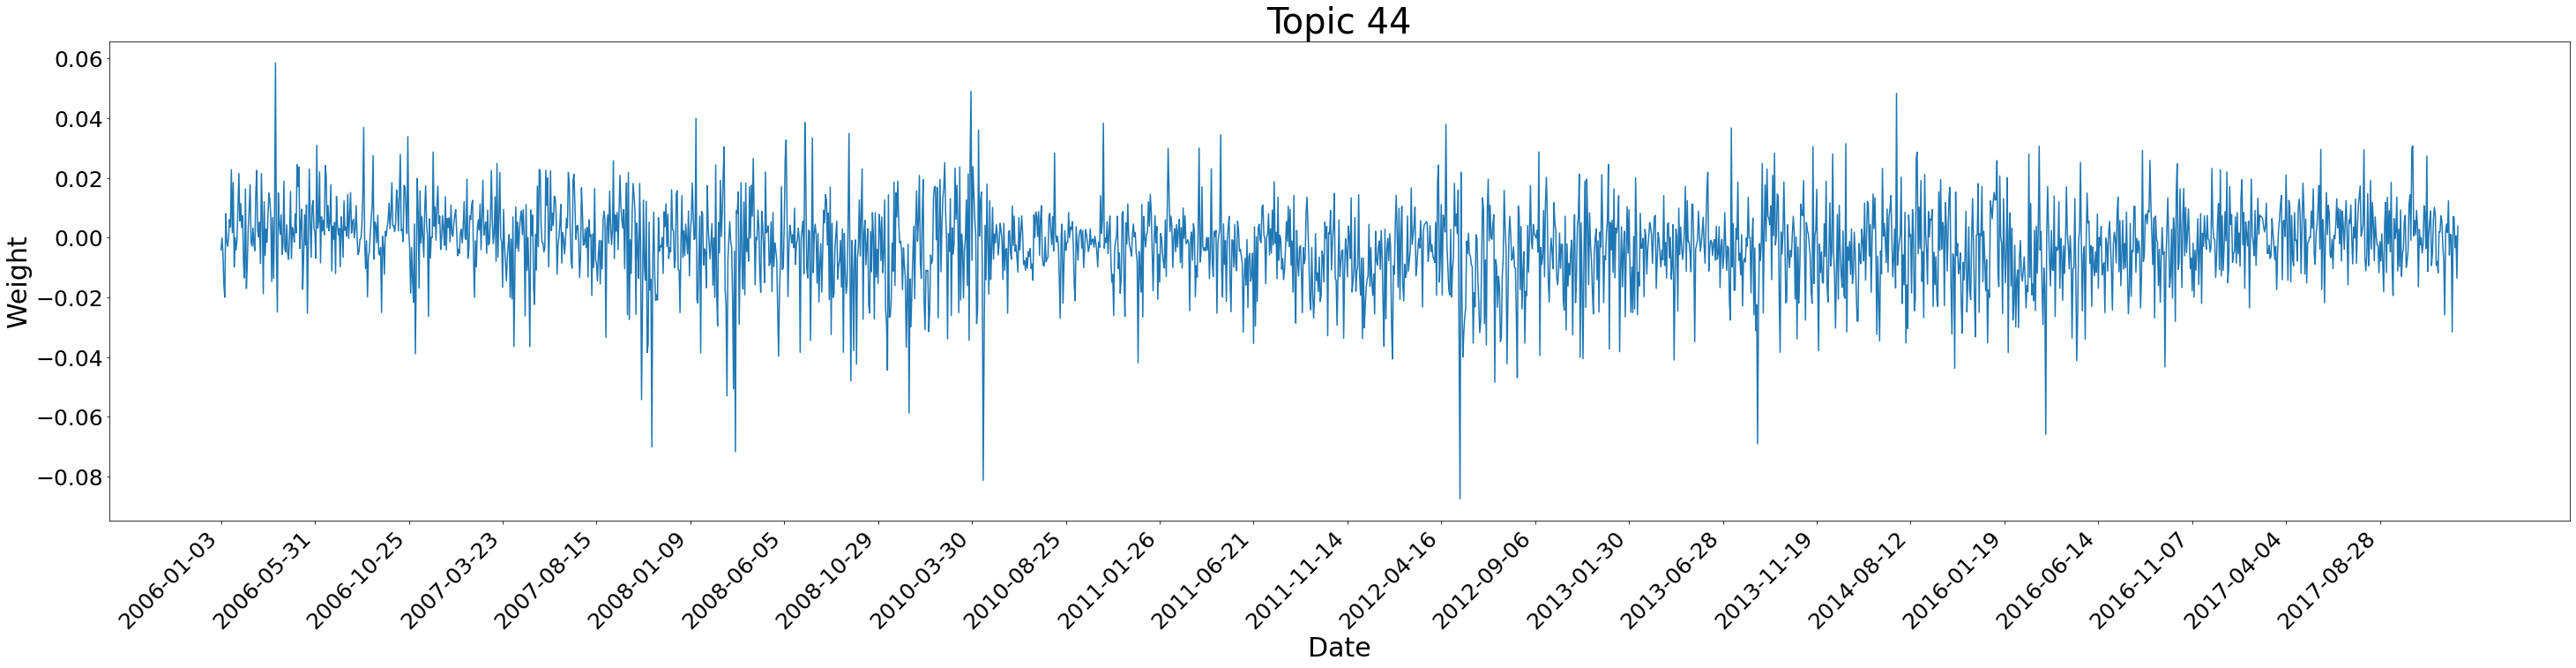

In [14]:
topic_weights = np.array(weights_1)
dates = np.array(dates)

#plot each of the time-series relative weights of the topics
#again using months so that we can have a representative number of documents while avoiding getting overly granular using daily data
plt.rcParams["figure.figsize"] = (50,10)
for i in range(44, 45): #tops):
    plt.xlabel('Date', fontsize=30)
    plt.ylabel('Weight', fontsize=30)
    plt.title('Topic '+str(i), fontsize=40)
    plt.tick_params(axis='both',labelsize=25)
    plt.xticks(rotation=45, ha='right')
    plt.plot(dates, topic_weights[:,i])
    xticks = plt.gca().xaxis.get_major_ticks()
    for i in range(len(xticks)):
        if i % 100 != 0:
            xticks[i].set_visible(False)
    plt.show()

In [8]:
all_weights = [weights_1, weights_2, weights_3_pos, weights_3_neg, weights_4_pos, weights_4_neg]

In [9]:
series = 'VIXCLS'

fred_data = get_fred_data(param_list=[series], start_date='2006-01-01', end_date='2017-12-31')

fred_data['VIXCLS'][0] = 0.0

ind_data = fred_data

In [10]:
index_growth = np.array(ind_data['VIXCLS'].tolist())
ind_dates = ind_data.index.tolist()

ind_dates = [date_obj.strftime('%Y%m%d') for date_obj in ind_dates]

inds = []
for i in range(0, len(dates)):
    if dates[i].replace('-','') not in ind_dates:
        inds.append(i)

dates_clean = [i for j, i in enumerate(dates) if j not in inds]        

for w in all_weights:
     w = [i for j, i in enumerate(w) if j not in inds]


c = 0
for i in range(0, len(ind_dates)):
    if ind_dates[i][0:4]+'-'+ind_dates[i][4:6]+'-'+ind_dates[i][6:] not in dates:
        ind_data.drop(index=ind_dates[i][0:4]+'-'+ind_dates[i][4:6]+'-'+ind_dates[i][6:], inplace = True)
    else:         
        c += 1


In [11]:
vixcls = np.array(ind_data['VIXCLS'].tolist())
dates_1 = np.array(dates_clean)

sents = [] 

for w in all_weights:
    w = pd.DataFrame(w)
    w['VIXCLS'] = vixcls
    w['date'] = dates_1

    sents.append(w)


In [12]:
sents[0].to_csv('C:/Users/senic/OneDrive/Desktop/Masters/WINTER_2021/ECO2460/Term_Paper/Code/Sentiment/lasso_input/var_50_sent_scale_V5_DS2_1_negscale.csv')
